# Loading Data and Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme(color_codes=True)

import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score, log_loss
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [4]:
# check if missing values present in data and remove rows with missing values
if df.isnull().values.any():
    df = df.dropna()

# drop duplicate rows
df = df.drop_duplicates()

df.shape

(302, 14)

## 1. Exploratory data analysis

In [5]:
# check if target variable ('target') is balanced or not

df['target'].value_counts()

target
1    164
0    138
Name: count, dtype: int64

## 1.1 Categorical data

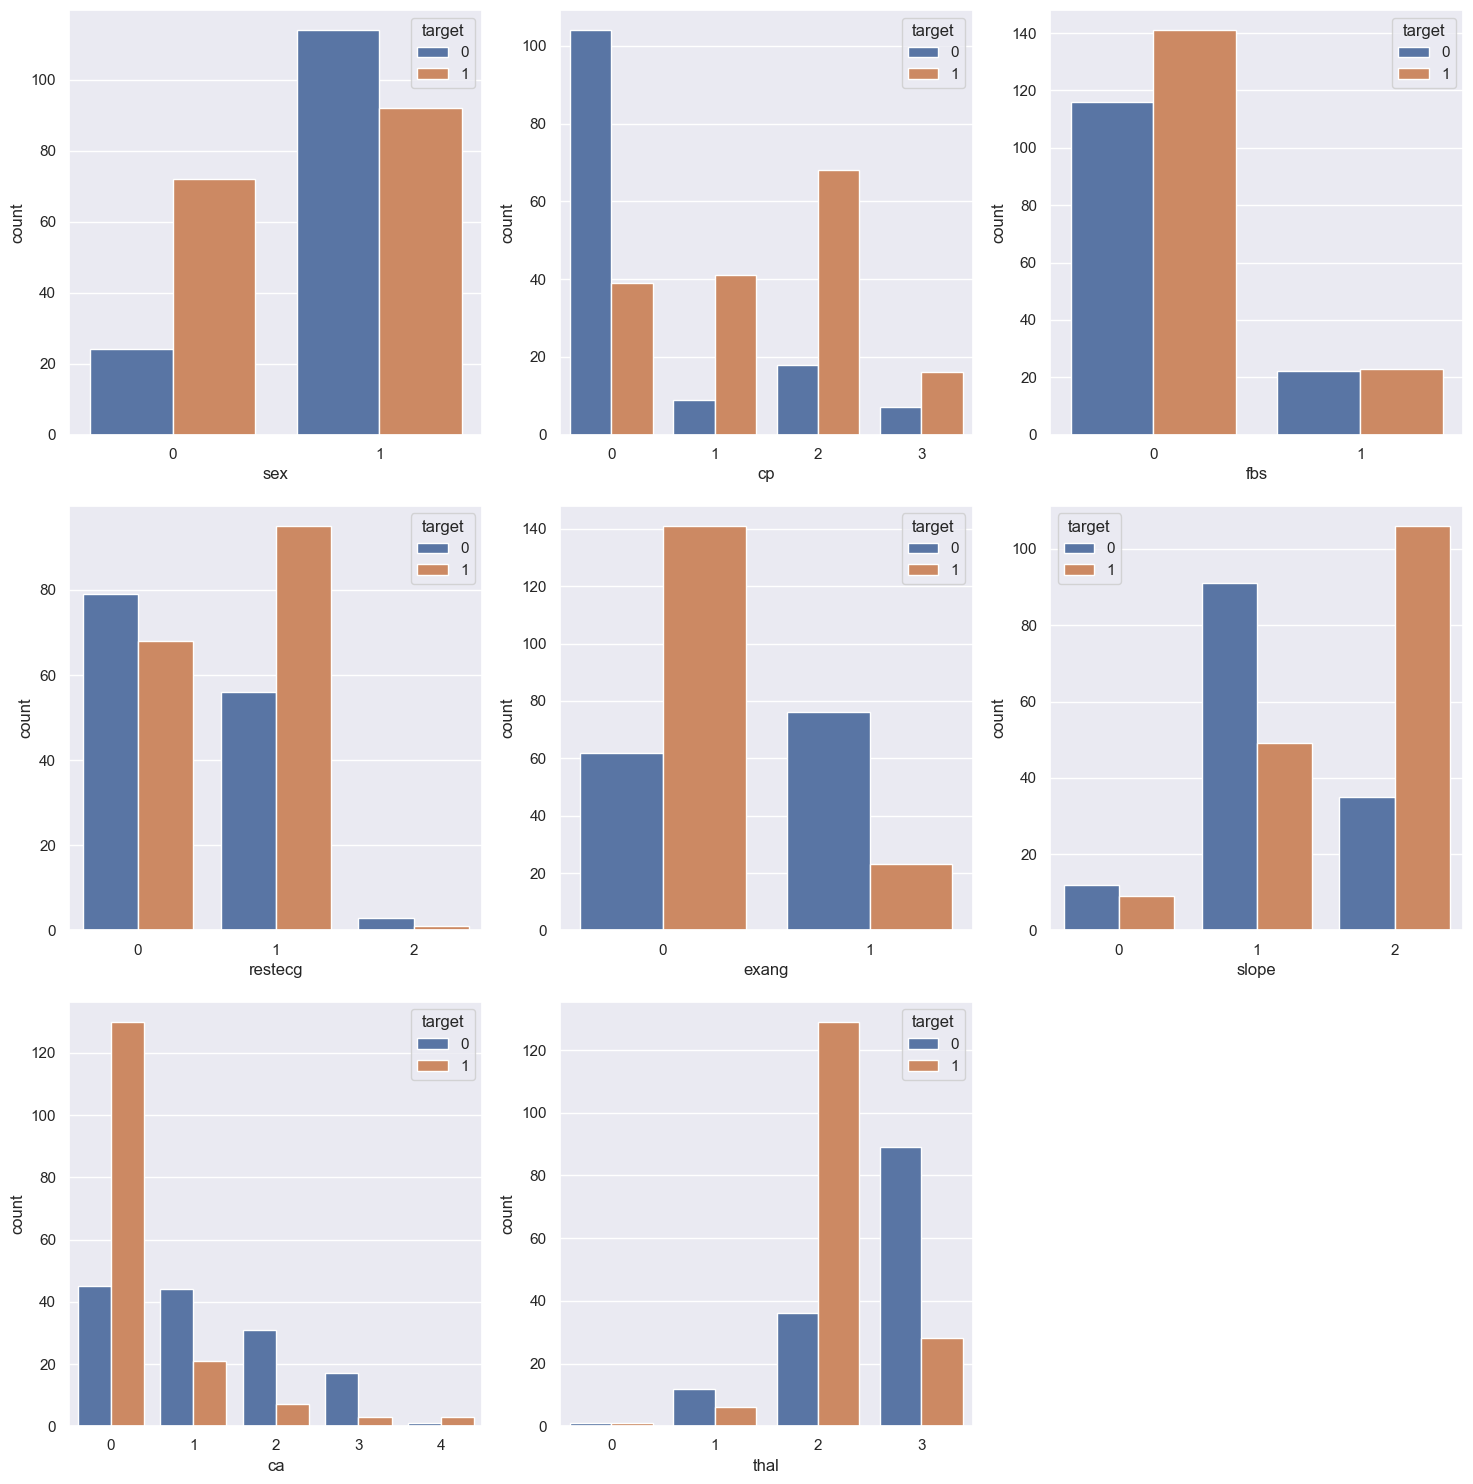

In [6]:
# list of categorical variables to plot
cat_vars = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# create figure with subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axs = axs.flatten()

# create barplot for each categorical variable
for i, var in enumerate(cat_vars):
    sns.countplot(x=var, hue='target', data=df, ax=axs[i])
    #axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)

# adjust spacing between subplots
fig.tight_layout()
axs[8].remove()

# show plot
plt.show()

## 1.2 Numerical Data

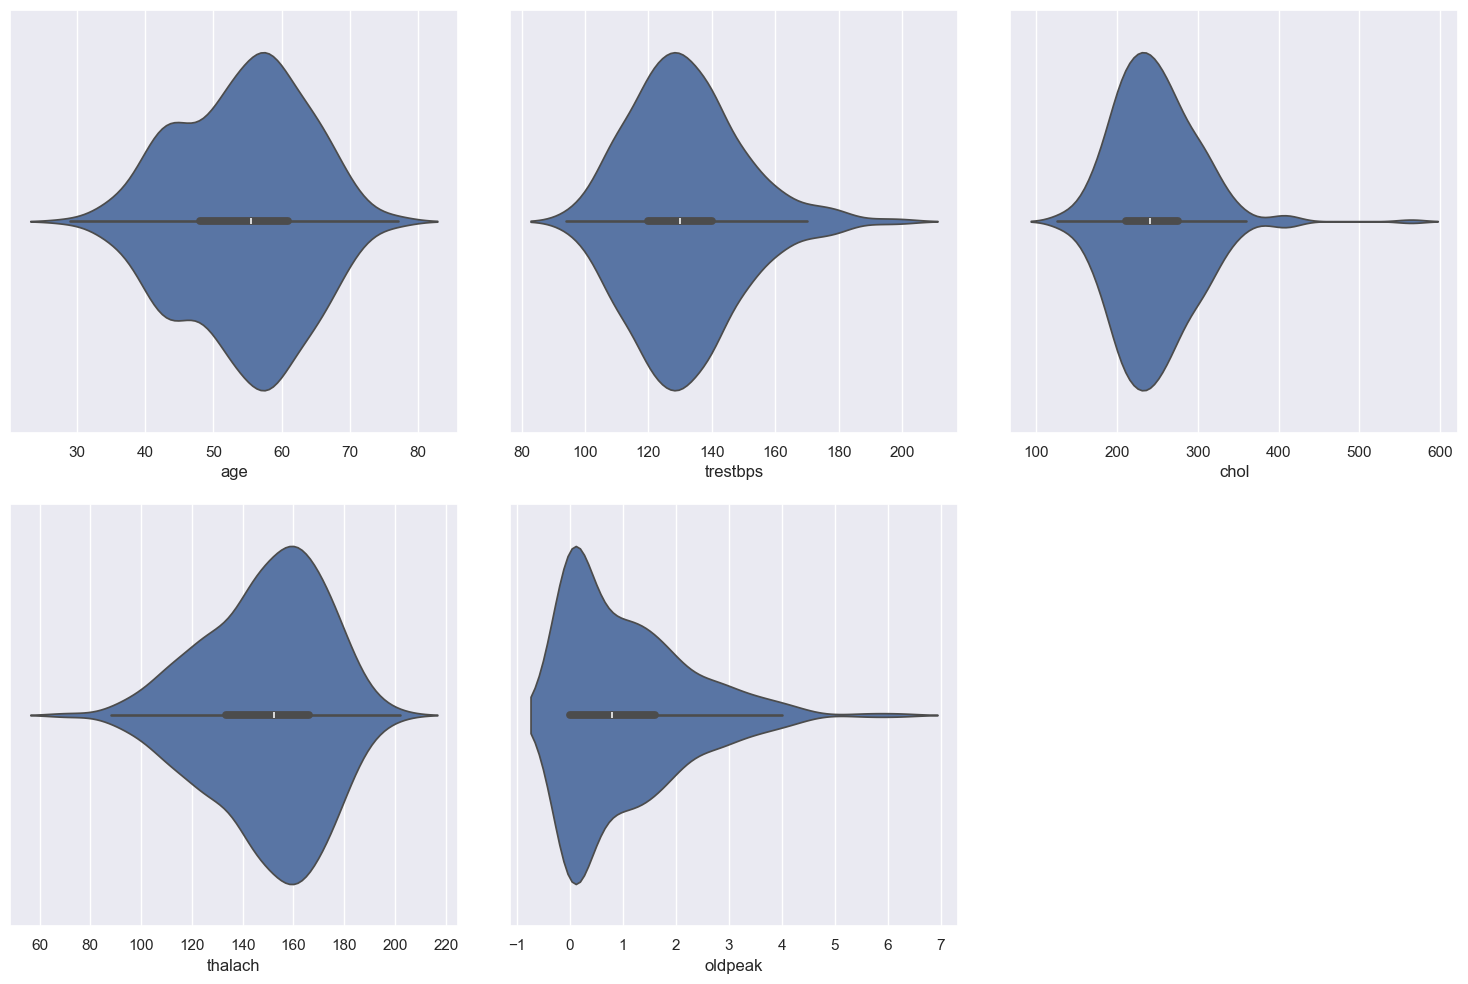

In [7]:
num_vars = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axs = axs.flatten()

for i, var in enumerate(num_vars):
    sns.violinplot(x=var, data=df, ax=axs[i])

fig.tight_layout()
axs[5].remove()

plt.show()

<Axes: >

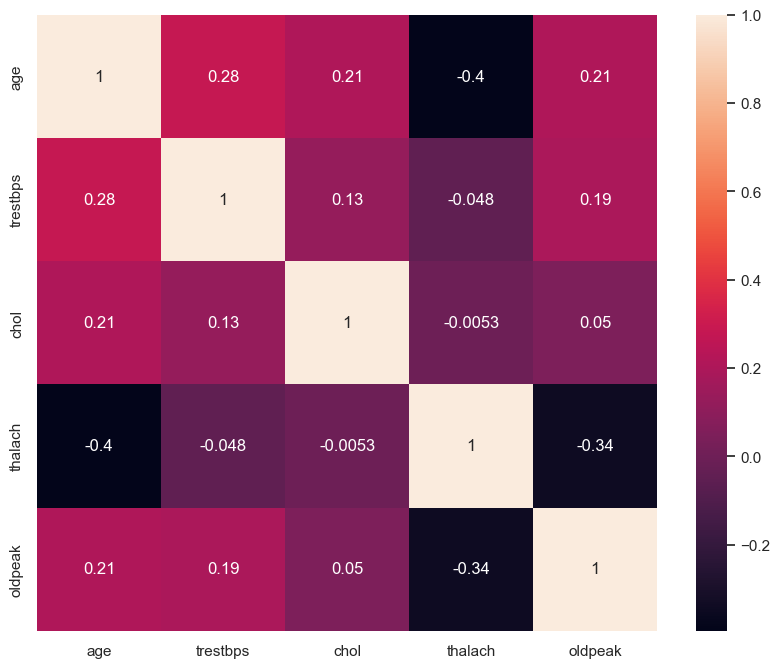

In [8]:
#Correlation Heatmap

df_num_vars = df[num_vars]

plt.figure(figsize=(10, 8))
sns.heatmap(df_num_vars.corr(), fmt='.2g', annot=True)


## 2. Training, cross-validation, test sets

In [9]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.2, random_state=0)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5, random_state=0)


## 3. Models

## 3.1 Decision Tree

In [10]:
dtree = DecisionTreeClassifier()

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4]
}

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(dtree, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

{'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 3}


In [11]:
dtree_best = DecisionTreeClassifier(random_state=0, max_depth=3, min_samples_leaf=1, min_samples_split=2)
dtree_best.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [12]:
y_pred_cv = dtree_best.predict(X_cv)

print("Cross-validation Set")
print("Accuracy Score :", round(accuracy_score(y_cv, y_pred_cv)*100 ,2), "%")
print('F-1 Score : ',(f1_score(y_cv, y_pred_cv, average='micro')))
print('Precision Score : ',(precision_score(y_cv, y_pred_cv, average='micro')))
print('Recall Score : ',(recall_score(y_cv, y_pred_cv, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_cv, y_pred_cv, average='micro')))
print('Log Loss : ',(log_loss(y_cv, y_pred_cv)))

y_pred_test = dtree_best.predict(X_test)

print("\nTest Set")
print("Accuracy Score :", round(accuracy_score(y_test, y_pred_test)*100 ,2), "%")
print('F-1 Score : ',(f1_score(y_test, y_pred_test, average='micro')))
print('Precision Score : ',(precision_score(y_test, y_pred_test, average='micro')))
print('Recall Score : ',(recall_score(y_test, y_pred_test, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_test, y_pred_test, average='micro')))
print('Log Loss : ',(log_loss(y_test, y_pred_test)))

Cross-validation Set
Accuracy Score : 66.67 %
F-1 Score :  0.6666666666666666
Precision Score :  0.6666666666666666
Recall Score :  0.6666666666666666
Jaccard Score :  0.5
Log Loss :  12.014551129705717

Test Set
Accuracy Score : 80.65 %
F-1 Score :  0.8064516129032258
Precision Score :  0.8064516129032258
Recall Score :  0.8064516129032258
Jaccard Score :  0.6756756756756757
Log Loss :  6.976190978538803


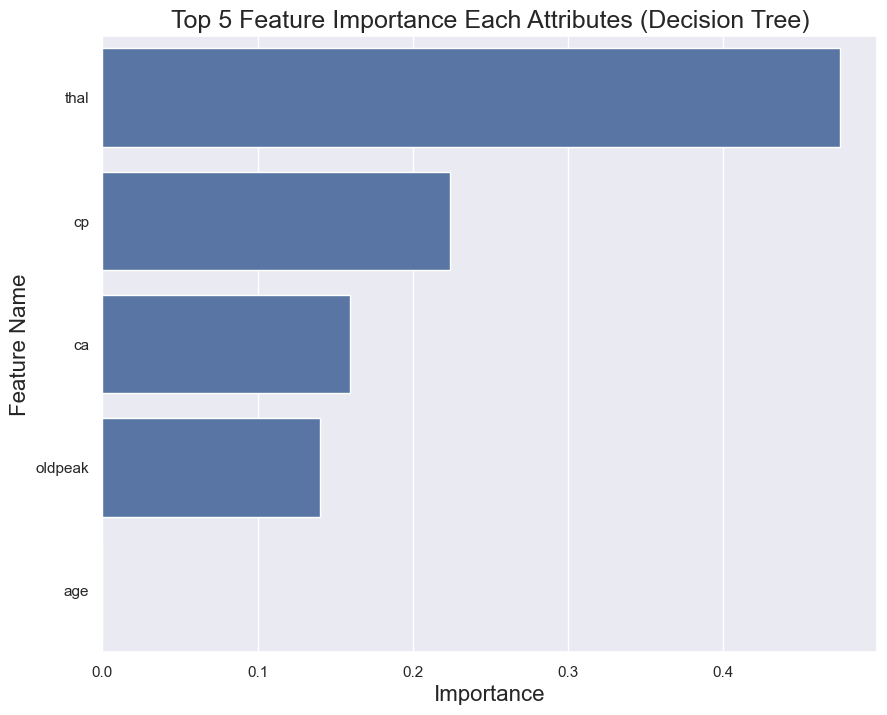

In [13]:
imp_df = pd.DataFrame({
    "Feature Name": X_train.columns,
    "Importance": dtree_best.feature_importances_
})
fi = imp_df.sort_values(by="Importance", ascending=False)

fi2 = fi.head(5)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Top 5 Feature Importance Each Attributes (Decision Tree)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()

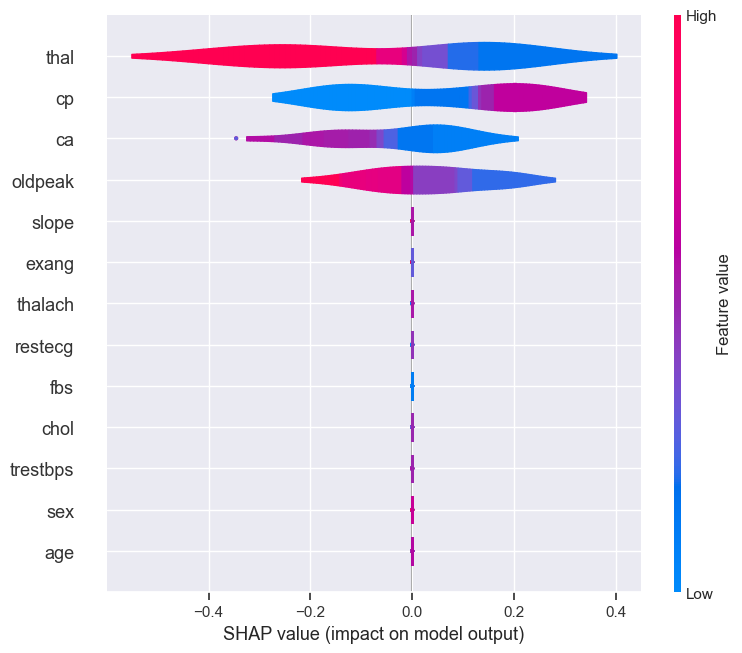

In [14]:
explainer = shap.TreeExplainer(dtree_best)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test.values, feature_names = X_test.columns, plot_type="violin")

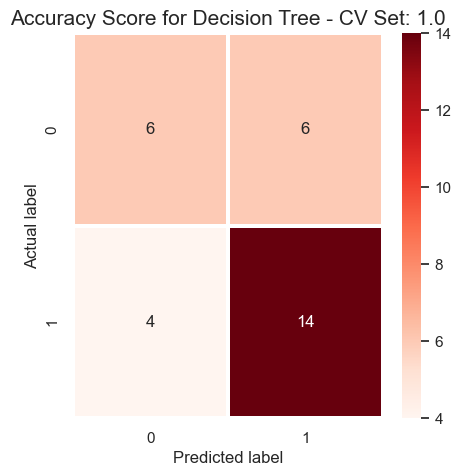

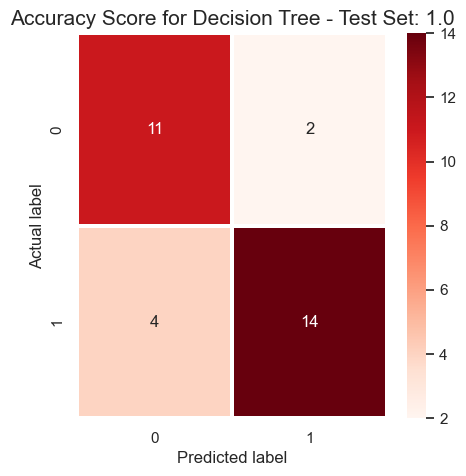

In [15]:
conf_mtx = confusion_matrix(y_cv, y_pred_cv)

plt.figure(figsize=(5,5))

sns.heatmap(data=conf_mtx,linewidths=1.5, annot=True,  cmap = 'Reds')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for Decision Tree - CV Set: {0}'.format(dtree_best.score(X_cv, y_pred_cv))
plt.title(all_sample_title, size = 15)


conf_mtx = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5,5))

sns.heatmap(data=conf_mtx,linewidths=1.5, annot=True,  cmap = 'Reds')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for Decision Tree - Test Set: {0}'.format(dtree_best.score(X_test, y_pred_test))
plt.title(all_sample_title, size = 15)

plt.show()

# 3.2 Random Forest

In [16]:
rfc = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(rfc, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

{'max_depth': 5, 'max_features': 'log2', 'n_estimators': 200}


In [17]:
rfc_best = RandomForestClassifier(random_state=0, max_features='sqrt', n_estimators=100, max_depth=5)
rfc_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=0)

In [18]:
y_pred_cv = rfc_best.predict(X_cv)

print("Cross-validation Set")
print("Accuracy Score :", round(accuracy_score(y_cv, y_pred_cv)*100 ,2), "%")
print('F-1 Score : ',(f1_score(y_cv, y_pred_cv, average='micro')))
print('Precision Score : ',(precision_score(y_cv, y_pred_cv, average='micro')))
print('Recall Score : ',(recall_score(y_cv, y_pred_cv, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_cv, y_pred_cv, average='micro')))
print('Log Loss : ',(log_loss(y_cv, y_pred_cv)))

y_pred_test = rfc_best.predict(X_test)

print("\nTest Set")
print("Accuracy Score :", round(accuracy_score(y_test, y_pred_test)*100 ,2), "%")
print('F-1 Score : ',(f1_score(y_test, y_pred_test, average='micro')))
print('Precision Score : ',(precision_score(y_test, y_pred_test, average='micro')))
print('Recall Score : ',(recall_score(y_test, y_pred_test, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_test, y_pred_test, average='micro')))
print('Log Loss : ',(log_loss(y_test, y_pred_test)))

Cross-validation Set
Accuracy Score : 83.33 %
F-1 Score :  0.8333333333333334
Precision Score :  0.8333333333333334
Recall Score :  0.8333333333333334
Jaccard Score :  0.7142857142857143
Log Loss :  6.007275564852859

Test Set
Accuracy Score : 83.87 %
F-1 Score :  0.8387096774193549
Precision Score :  0.8387096774193549
Recall Score :  0.8387096774193549
Jaccard Score :  0.7222222222222222
Log Loss :  5.813492482115669


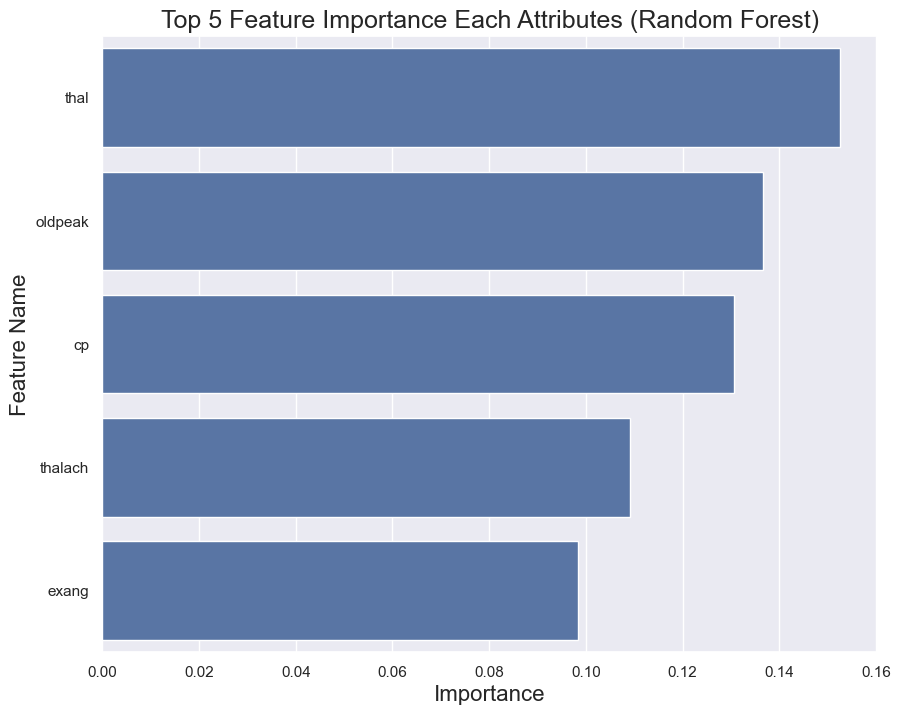

In [19]:
imp_df = pd.DataFrame({
    "Feature Name": X_train.columns,
    "Importance": rfc_best.feature_importances_
})
fi = imp_df.sort_values(by="Importance", ascending=False)

fi2 = fi.head(5)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Top 5 Feature Importance Each Attributes (Random Forest)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()

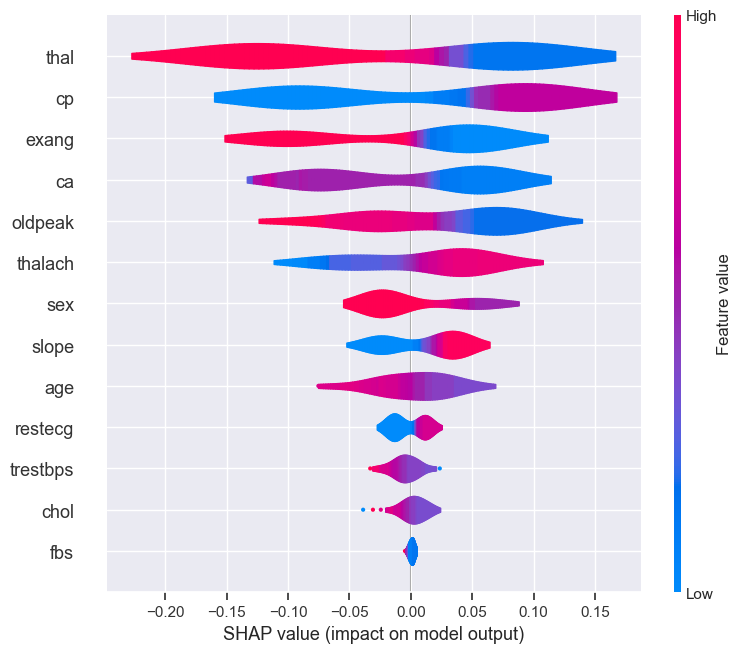

In [20]:
import shap

explainer = shap.TreeExplainer(rfc_best)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test.values, feature_names = X_test.columns, plot_type="violin")

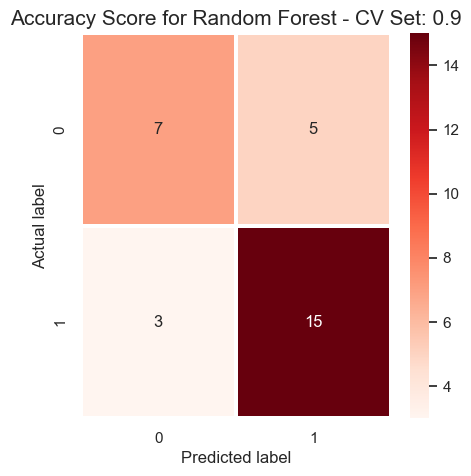

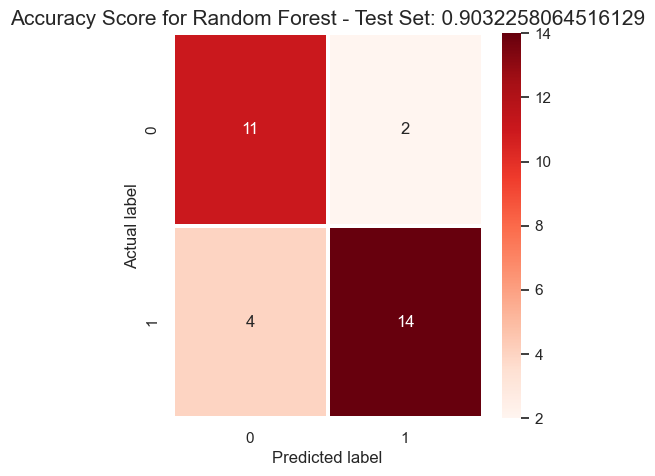

In [29]:
conf_mtx = confusion_matrix(y_cv, y_pred_cv)

plt.figure(figsize=(5,5))

sns.heatmap(data=conf_mtx,linewidths=1.5, annot=True,  cmap = 'Reds')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for Random Forest - CV Set: {0}'.format(rfc_best.score(X_cv, y_pred_cv))
plt.title(all_sample_title, size = 15)


conf_mtx = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5,5))

sns.heatmap(data=conf_mtx,linewidths=1.5, annot=True,  cmap = 'Reds')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for Random Forest - Test Set: {0}'.format(rfc_best.score(X_test, y_pred_test))
plt.title(all_sample_title, size = 15)

plt.show()

# 3.3 Extreme Gradient Boosting (XGBOOST)

In [22]:
xgb = XGBClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.1, 0.3],
}

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(xgb, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50}


In [23]:
xgb_best = XGBClassifier(random_state=0, learning_rate=0.3, n_estimators=50, max_depth=3)
xgb_best.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [24]:
y_pred_cv = xgb_best.predict(X_cv)

print("Cross-validation Set")
print("Accuracy Score :", round(accuracy_score(y_cv, y_pred_cv)*100 ,2), "%")
print('F-1 Score : ',(f1_score(y_cv, y_pred_cv, average='micro')))
print('Precision Score : ',(precision_score(y_cv, y_pred_cv, average='micro')))
print('Recall Score : ',(recall_score(y_cv, y_pred_cv, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_cv, y_pred_cv, average='micro')))
print('Log Loss : ',(log_loss(y_cv, y_pred_cv)))

y_pred_test = xgb_best.predict(X_test)

print("\nTest Set")
print("Accuracy Score :", round(accuracy_score(y_test, y_pred_test)*100 ,2), "%")
print('F-1 Score : ',(f1_score(y_test, y_pred_test, average='micro')))
print('Precision Score : ',(precision_score(y_test, y_pred_test, average='micro')))
print('Recall Score : ',(recall_score(y_test, y_pred_test, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_test, y_pred_test, average='micro')))
print('Log Loss : ',(log_loss(y_test, y_pred_test)))

Cross-validation Set
Accuracy Score : 73.33 %
F-1 Score :  0.7333333333333333
Precision Score :  0.7333333333333333
Recall Score :  0.7333333333333333
Jaccard Score :  0.5789473684210527
Log Loss :  9.611640903764572

Test Set
Accuracy Score : 80.65 %
F-1 Score :  0.8064516129032258
Precision Score :  0.8064516129032258
Recall Score :  0.8064516129032258
Jaccard Score :  0.6756756756756757
Log Loss :  6.976190978538803


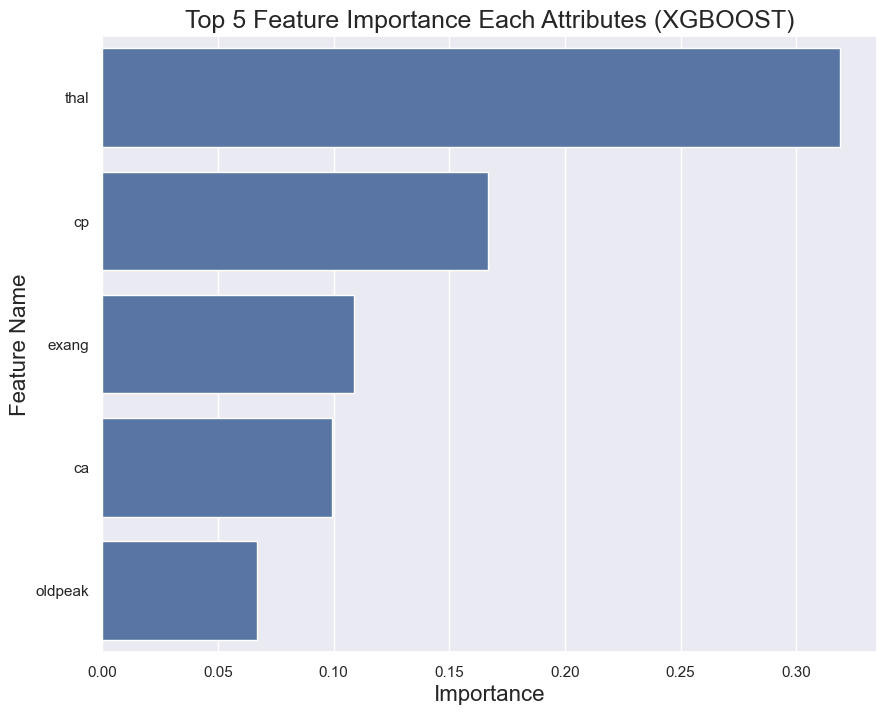

In [25]:
imp_df = pd.DataFrame({
    "Feature Name": X_train.columns,
    "Importance": xgb_best.feature_importances_
})
fi = imp_df.sort_values(by="Importance", ascending=False)

fi2 = fi.head(5)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Top 5 Feature Importance Each Attributes (XGBOOST)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()

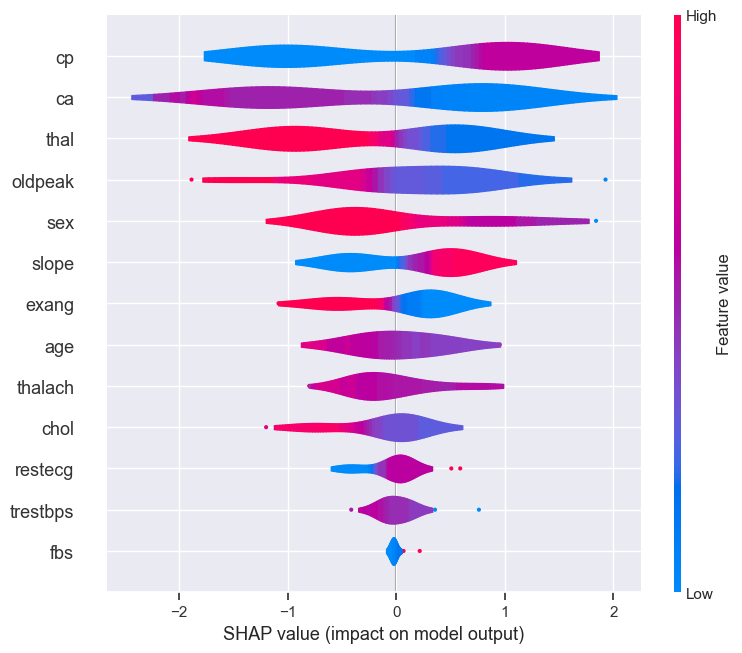

In [28]:
import shap

explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test.values, feature_names = X_test.columns, plot_type="violin")

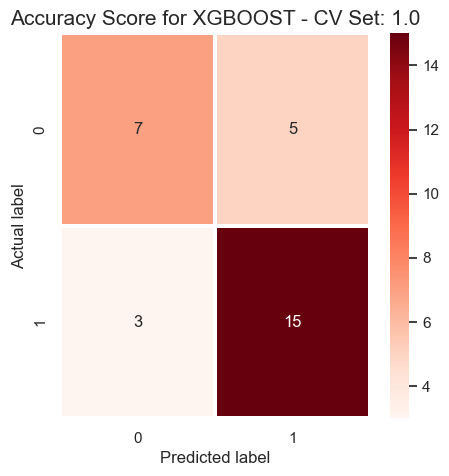

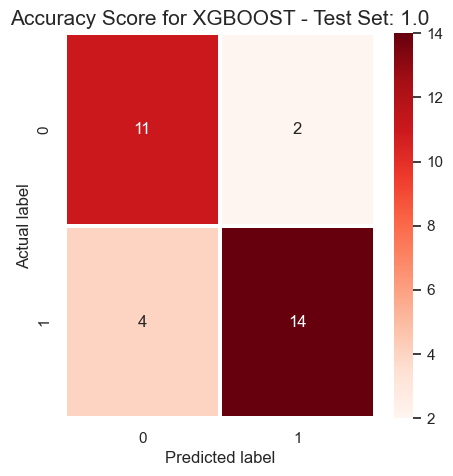

In [31]:
conf_mtx = confusion_matrix(y_cv, y_pred_cv)

plt.figure(figsize=(5,5))

sns.heatmap(data=conf_mtx,linewidths=1.5, annot=True,  cmap = 'Reds')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for XGBOOST - CV Set: {0}'.format(xgb_best.score(X_cv, y_pred_cv))
plt.title(all_sample_title, size = 15)


conf_mtx = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5,5))

sns.heatmap(data=conf_mtx,linewidths=1.5, annot=True,  cmap = 'Reds')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for XGBOOST - Test Set: {0}'.format(xgb_best.score(X_test, y_pred_test))
plt.title(all_sample_title, size = 15)

plt.show()